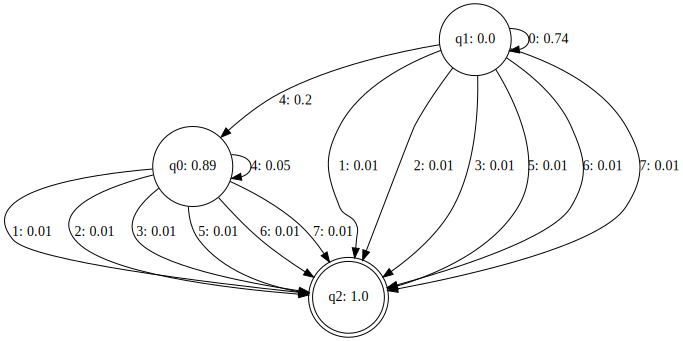

In [38]:

# %load_ext autoreload
%autoreload 2
import pdfa

pdfa = pdfa.PDFA(configFileName='config/pdfa_self_driving_config.yaml')

numSamples = 1e5
traces, traceLengths = pdfa.generateTraces(numSamples)

fName = 'PDFASamples_train.swag'
pdfa.writeTracesToFile(fName, traces, numSamples, traceLengths)

pdfa.drawIPython()

# Flexfringe Usage

Two choices: Using it via Python function calls, or working with the command line.

## Step 1

Install all dependencies and compile flexfringe (development branch due to some technicalities using WIFEXITED macro used for the SAT solver's process)

In [ ]:
# for the C++ code
!apt install graphviz
!apt install libgsl-dev
!apt install libpopt-dev

# for visualization and notebook interface
!pip install graphviz

# Stamina data
!wget http://stamina.chefbe.net/downloads/grid.tar.gz
!tar xfz grid.tar.gz

# cloning the repository
!rm -rf dfasat
!git clone https://bitbucket.org/chrshmmmr/dfasat.git

In [ ]:
# building the repository
# it is important to check out the development branch on colab
!cd dfasat && git checkout  && make clean all

## Step 2 
Provide simple command line wrappers

In [15]:
import subprocess
import sys
import graphviz

from IPython.display import Image, display

def flexfringe(*args, **kwargs):

    command = ["--help"]

    if(len(kwargs) > 1):
        command = []
    for key in kwargs:
        command += ["-" + key + "=" + kwargs[key]]
    flexfringeCall = ["dfasat/flexfringe",] + command + [args[0]]
    callString = subprocess.run(flexfringeCall, 
                                stdout=subprocess.PIPE).stdout.decode()
    print("%s" % callString)

    try:
        with open("dfafinal.dot") as fh:
            return fh.read()
    except FileNotFoundError:
        print("No output file was generated.")
    return None
    
def show(data):
    if data=="":
        pass
    else:
        g = graphviz.Source(data, format="png")
        g.render()
        display(Image(g.render()))
 

In [ ]:
!ls dfasat/data/staminadata

## Step 3

call the flexfringe function with the filename and named arguments just as described in help. Mind that "heuristic-name" is actually an expression, not a valid name. Use the short form in this case.

The flexringe() call returns a string with the dot output.

```bash
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing /, default: 
                                  "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default count_driven. Use 
                                  any heuristic in the evaluation
                                  directory. It is often beneficial to write your own, as  
                                  heuristics are very application
                                  specific.
  -d, --data-name=string          Name of the merge data class to use; default count_data. Use 
                                  any heuristic in the evaluation
                                  directory.
  -M, --mode=string               batch or stream depending on the mode of operation
  -X, --evalpar=string            string of key-value pairs
  -m, --method=integer            Method to use when merging states, default value 1 is random 
                                  greedy (used in Stamina winner), 2
                                  is one standard (non-random) greedy.
  -s, --seed=integer              Seed for random merge heuristic; default=12345678
  -n, --runs=integer              Number of random greedy runs/iterations; default=1. Advice: 
                                  when using random greedy, a higher
                                  value is recommended (100 was used in Stamina winner).

Settings that modify the red-blue
                                  state-merging framework:
  -x, --extend=integer            When set to 1, any merge candidate (blue) that cannot be 
                                  merged with any target (red) is
                                  immediately changed into a (red) target; default=1. If set 
                                  to 0, a merge candidate is only
                                  changed into a target when no more merges are possible. 
                                  Advice: unclear which strategy is best,
                                  when using statistical (or count-based) consistency checks, 
                                  keep in mind that merge consistency
                                  between states may change due to other performed merges. 
                                  This will especially influence low
                                  frequency states. When there are a lot of those, we 
                                  therefore recommend setting x=0.
  -w, --shallowfirst=integer      When set to 1, the ordering of the nodes is changed from 
                                  most frequent first (default) to most
                                  shallow (smallest depth) first; default=0. Advice: use 
                                  depth-first when learning from
                                  characteristic samples.
  -a, --largestblue=integer       When set to 1, the algorithm only tries to merge the most 
                                  frequent (or most shallow if w=1)
                                  candidate (blue) states with any target (red) state, instead 
                                  of all candidates; default=0.
                                  Advice: this reduces run-time significantly but comes with a 
                                  potential decrease in merge
                                  quality.
  -b, --blueblue=integer          When set to 1, the algorithm tries to merge candidate (blue) 
                                  states with candiate (blue) states
                                  in addition to candidate (blue) target (red) merges; 
                                  default=0. Advice: this adds run-time to
                                  the merging process in exchange for potential improvement in 
                                  merge quality.
  -f, --finalred=integer          When set to 1, merges that add new transitions to red states 
                                  are considered inconsistent.
                                  Merges with red states will also not modify any of the 
                                  counts used in evaluation functions.
                                  Once a red state has been learned, it is considered final 
                                  and unmodifiable; default=0. Advice:
                                  setting this to 1 frequently results in easier to vizualize
                                  and more insightful models.

Settings that influece the use of sinks:
  -I, --sinkson=integer           Set to 1 to use sink states; default=1. Advice: leads to 
                                  much more concise and easier to
                                  vizualize models, but can cost predictive performance 
                                  depending on the sink definitions.
  -Q, --sinkcount=integer         The maximum number of occurrences of a state for it to be a 
                                  low count sink (see evaluation
                                  functions); default=10.
  -J, --mergesinks=integer        Sink nodes are candidates for merging during the greedy runs 
                                  (setting 0 or 1); default=0.
                                  Advice: merging sinks typically only makes the learned model 
                                  worse. Keep in mind that sinks can
                                  become non-sinks due to other merges that influcence the 
                                  occurrence counts.
  -K, --satmergesinks=integer     Merge all sink nodes of the same type before sending the 
                                  problem to the SAT solver (setting 0
                                  or 1); default=1. Advice: radically improves runtime, only 
                                  set to 0 when sinks of the same type
                                  can be different states in the final model.

Settings that influence merge evaluations:
  -t, --testmerge=integer         When set to 1, merge tries in order to compute the 
                                  evaluation scores do not actually perform
                                  the merges themselves. Thus the consistency and score 
                                  evaluation for states in merges that add
                                  recursive loops are uninfluenced by earlier merges; 
                                  default=0. Advice: setting this to 1
                                  reduces run-time and can be useful when learning models 
                                  using statistical evaluation functions,
                                  but can lead to inconsistencies when learning from labeled 
                                  data.
  -l, --lowerbound=float          Minimum value of the heuristic function, smaller values are 
                                  treated as inconsistent, also used
                                  as the paramater value in any statistical tests; default=-1. 
                                  Advice: state merging is forced to
                                  perform the merge with best heuristic value, it can 
                                  sometimes be better to color a state red
                                  rather then performing a bad merge. This is achieved using a 
                                  positive lower bound value. Models
                                  learned with positive lower bound are frequently more 
                                  interpretable.
  -q, --state_count=integer       The minimum number of positive occurrences of a state for it 
                                  to be included in
                                  overlap/statistical checks (see evaluation functions); 
                                  default=25. Advice: low frequency states
                                  can have an undesired influence on statistical tests, set to 
                                  at least 10. Note that different
                                  evaluation functions can use this parameter in different 
                                  ways.
  -y, --symbol_count=integer      The minimum number of positive occurrences of a 
                                  symbol/transition for it to be included in
                                  overlap/statistical checks, symbols with less occurrences 
                                  are binned together; default=10.
                                  Advice: low frequency transitions can have an undesired 
                                  influence on statistical tests, set to
                                  at least 4. Note that different evaluation functions can use 
                                  this parameter in different ways.
  -e, --epsilon=float             epsilon for Hoeffding condition
  -D, --delta=float               delta for Hoeffding condition
  -B, --batchsize=int             bachsize for streaming
  -c, --correction=float          Value of a Laplace correction (smoothing) added to all 
                                  symbol counts when computing statistical
                                  tests (in ALERGIA, LIKELIHOODRATIO, AIC, and KULLBACK-
                                  LEIBLER); default=0.0. Advice: unclear
                                  whether smoothing is needed for the different tests, more 
                                  smoothing typically leads to smaller
                                  models.
  -p, --extrapar=float            Extra parameter used during statistical tests, the 
                                  significance level for the likelihood ratio
                                  test, the alpha value for ALERGIA; default=0.5. Advice: look 
                                  up the statistical test performed,
                                  this parameter is not always the same as a p-value.

Settings influencing the SAT solving
                                  procedures:
  -S, --sat_program=string        Relative path from binary invokation to the desired sat 
                                  solver. tested to work with lingeling.
                                  e.g. -S ../lingeling/lingeling
  -A, --sataptabound=integer      Maximum number of remaining states in the partially learned 
                                  DFA before starting the SAT search
                                  process. The higher this value, the larger the problem sent 
                                  to the SAT solver; default=2000.
                                  Advice: try sending problem instances that are as large as 
                                  possible, since larger instances
                                  take more time, test what time is acceptable for you.
  -D, --satdfabound=integer       Maximum size of the partially learned DFA before starting 
                                  the SAT search process; default=50.
                                  Advice: when the merging process performs bad merges, it can 
                                  blow-up the size of the learned
                                  model. This test ensres that models that are too large do 
                                  not get solved.
  -E, --satextra=integer          DFASAT runs a SAT solver to find a solution of size at most 
                                  the size of the partially learned
                                  DFA + E; default=5. Advice: larger values greatly increases 
                                  run-time. Setting it to 0 is
                                  frequently sufficient (when the merge heuristic works well).
  -P, --satplus=int               With every iteration, DFASAT tries to find solutions of size 
                                  at most the best solution found +
                                  P, default=0. Advice: current setting only searches for 
                                  better solutions. If a few extra states
                                  is OK, set it higher.
  -F, --satfinalred=integer       Make all transitions from red states without any occurrences 
                                  force to have 0 occurrences
                                  (similar to targeting a rejecting sink), (setting 0 or 1) 
                                  before sending the problem to the SAT
                                  solver; default=0. Advice: the same as finalred but for the 
                                  SAT solver. Setting it to 1 greatly
                                  improves solving speed.
  -Y, --satsymmetry=integer       Add symmetry breaking predicates to the SAT encoding 
                                  (setting 0 or 1), based on Ulyantsev et
                                  al. BFS symmetry breaking; default=1. Advice: in our 
                                  experience this only improves solving
                                  speed.
  -O, --satonlyinputs=integer     Add predicates to the SAT encoding that force transitions in 
                                  the learned DFA to be used by
                                  input examples (setting 0 or 1); default=0. Advice: leads to 
                                  non-complete models. When the data
                                  is sparse, this should be set to 1. It does make the 
                                  instance larger and can have a negative
                                  effect on the solving time.
```

In [36]:
data = flexfringe("PDFASamples_train.swag",
                  h="kldistance",
                  d="kl_data")

welcome, running git commit bea192cc5abfd8bd4e1121472f875eea2ea6da69 with: dfasat/flexfringe -h=kldistance -d=kl_data PDFASamples_train.swag 
sat_program : 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running x148942  x98778  x71976  x61544  x40562  x37812  x30132  x29874  x22580  x21274  x18906  x15898  x12601  x11162  x10816  x10816  x9882  x6874  x6144  x5402  x5402  x5184  x4544  x4416  x4410  x3776  x2304  x2272  x2240  x2240  x1965  x1568  x1504  x1504  x1504  x1004  x832  x832  x800  x800  x800  x800  x800  x800  x768  x768  x768  x768  x768  x768  

found intermediate solution with 110 an

## Step 4
Visualize the output by feeding the dot string to the show() function.

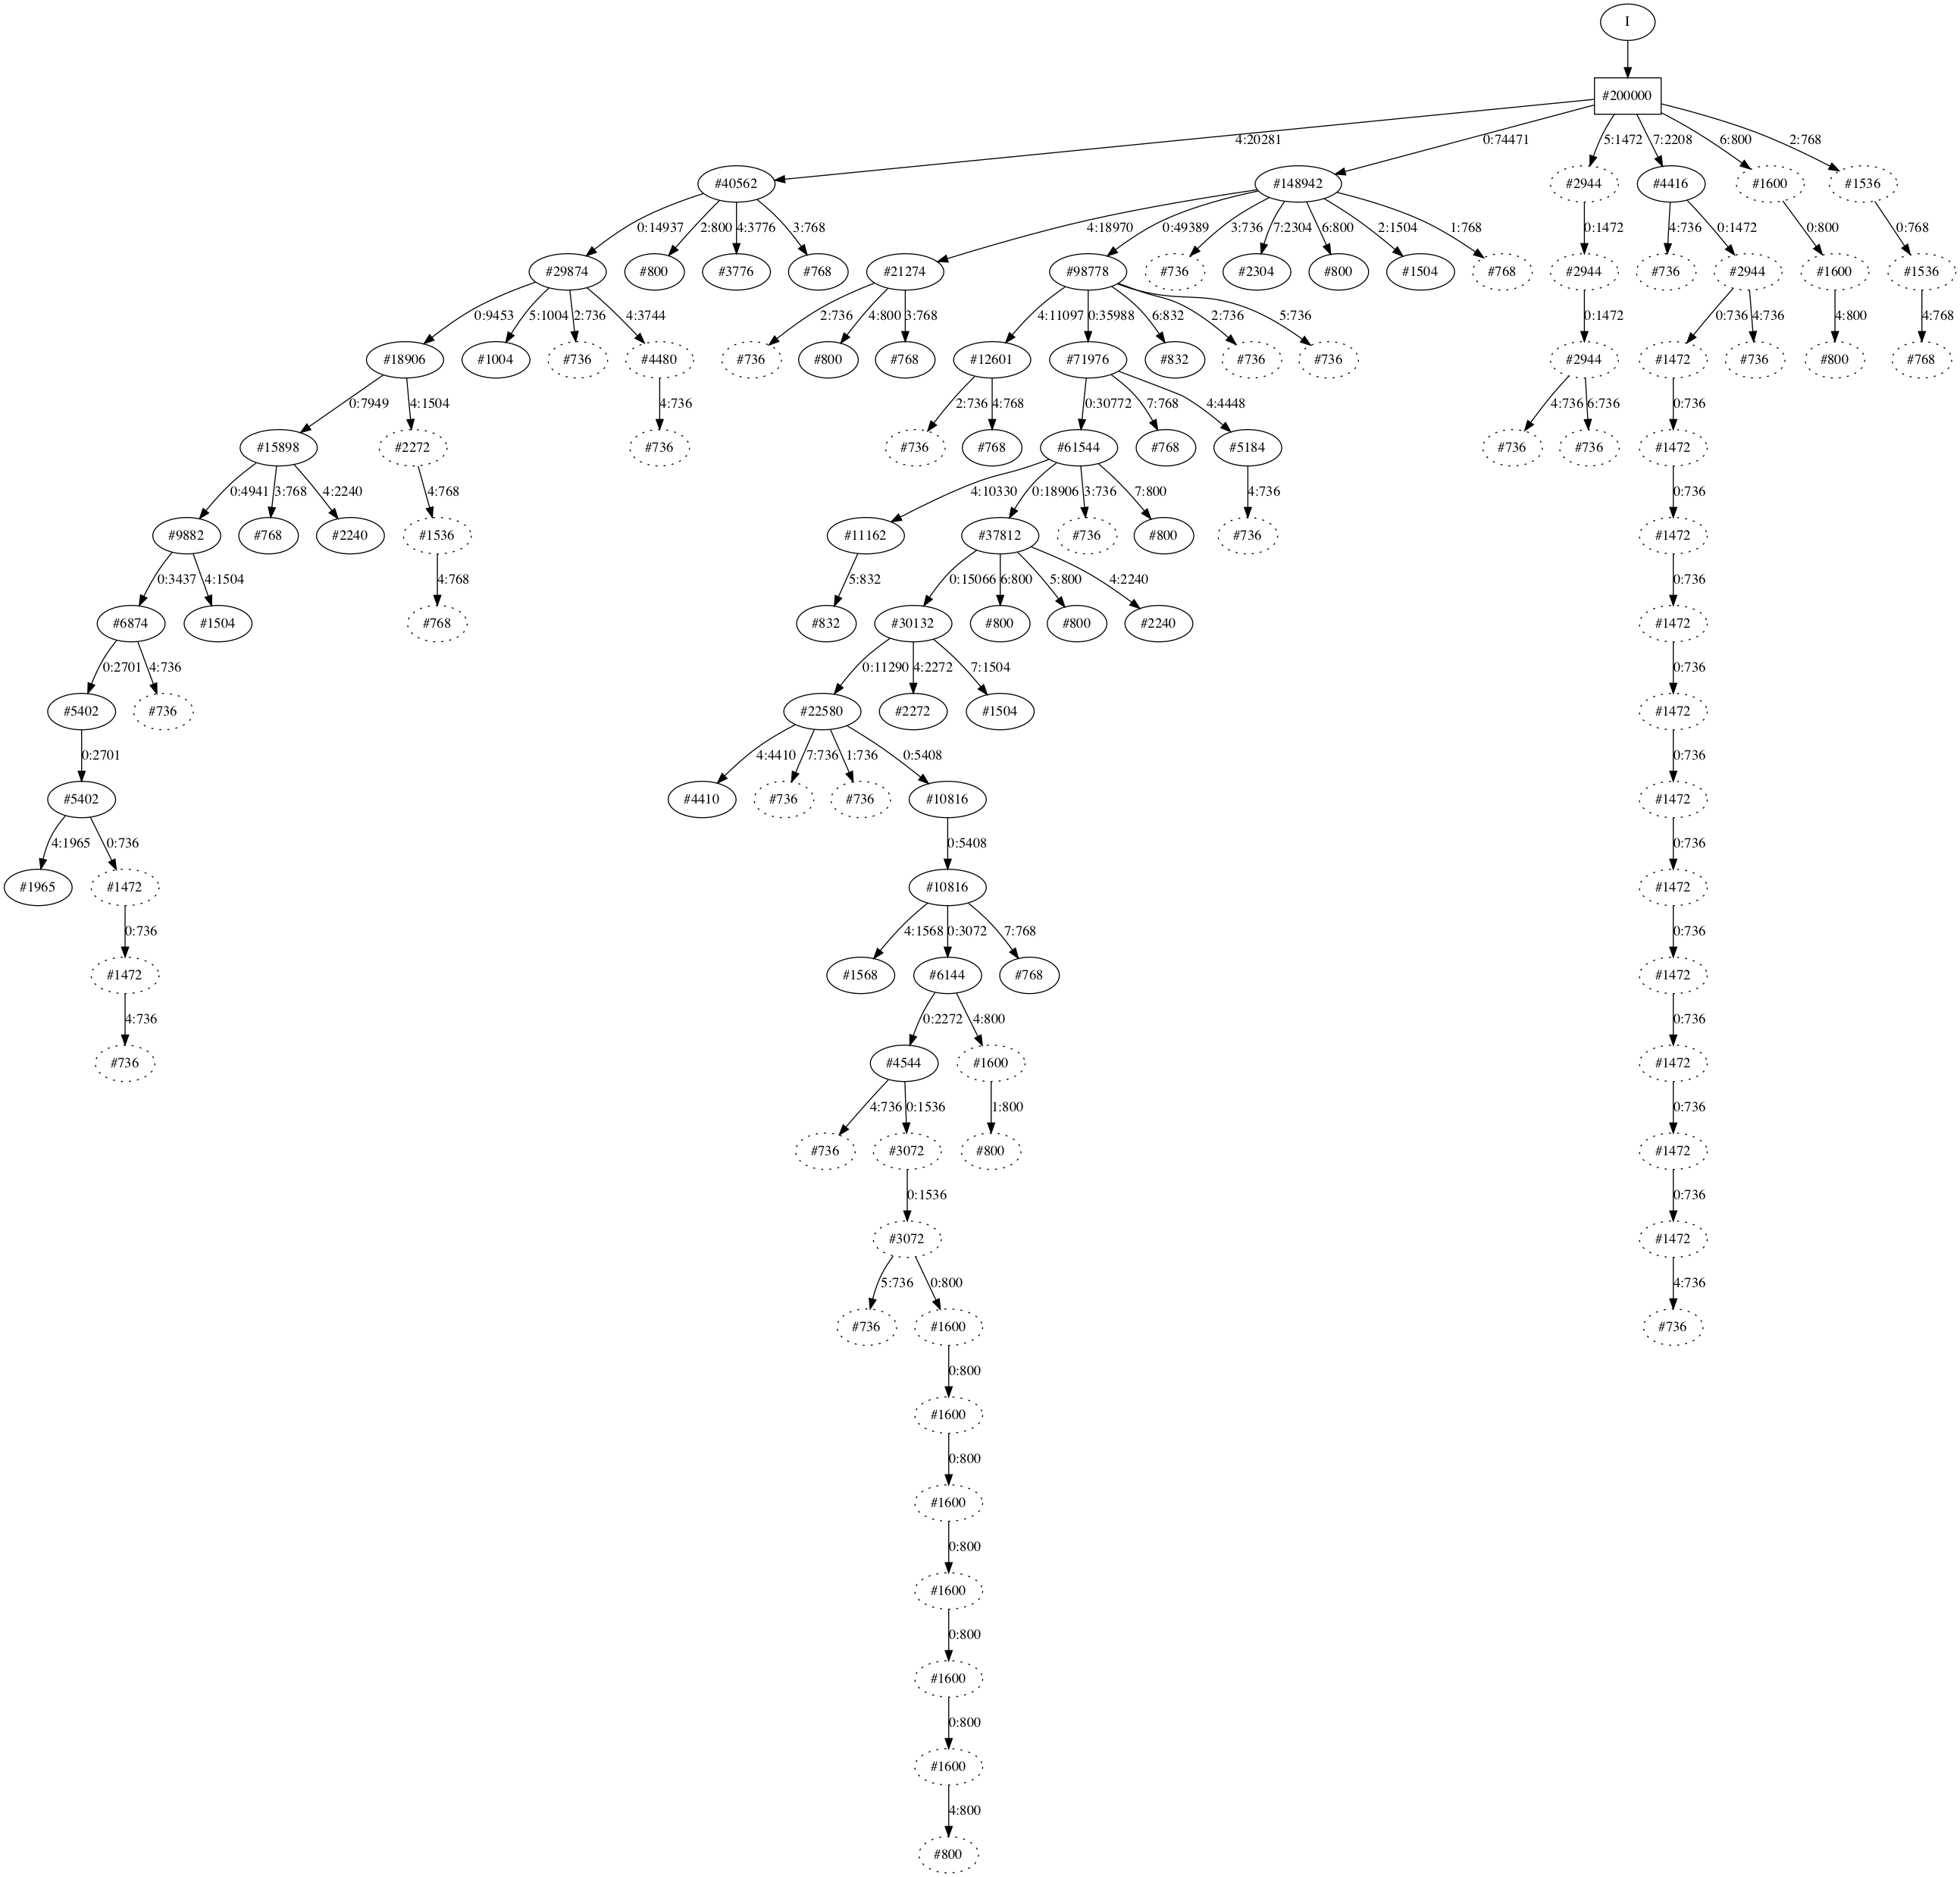

In [37]:
show(data)

## Step 5

Compare with a direct command line. Each cell can act as a shell by prepending a bang ! to the commands.

In [ ]:
# !dfasat/flexfringe -h=overlap_driven -d=overlap_data /content/grid/1_training.txt 
!dfasat/flexfringe --help

In [ ]:
!dot -Tpng dfafinal.dot > outfile.png

## Step 6

Visualize the files using inline Python calls, e.g. display and Image

In [ ]:
display(Image("outfile.png"))